In [1]:
using Revise

In [2]:
using LazySets
using ModelVerification

In [3]:
using PyCall
using CSV
using ONNX
using Flux
using DataFrames

In [ ]:
include("vnnlib_parser.jl")

In [7]:

function onnx_to_nnet(onnx_file)
    pushfirst!(PyVector(pyimport("sys")."path"), @__DIR__)
    nnet = pyimport("NNet")
    use_gz = split(onnx_file, ".")[end] == "gz"
    if use_gz
        onnx_file = onnx_file[1:end-3]
    end
    nnet_file = onnx_file[1:end-4] * "nnet"
    isfile(nnet_file) && return
    nnet.onnx2nnet(onnx_file, nnetFile=nnet_file)
end

function verify_an_instance(onnx_file, spec_file, timeout)
    use_gz = split(onnx_file, ".")[end] == "gz"
    nnet_file = use_gz ? onnx_file[1:end-7] * "nnet" : onnx_file[1:end-4] * "nnet"
    net = ModelVerification.read_nnet(nnet_file)
    ###### TODO: change this ad-hoc remedy for nnet read ######
    net.layers[1] = ModelVerification.Layer(net.layers[1].weights, net.layers[1].bias, ModelVerification.Id())
    flux_model = Flux.Chain(net)
    n_in = size(net.layers[1].weights)[2]
    n_out = length(net.layers[end].bias)
    specs = read_vnnlib_simple(spec_file, n_in, n_out)
    current_time = 0
    for spec in specs
        X_range, Y_cons = spec
        lb = [bd[1] for bd in X_range]
        ub = [bd[2] for bd in X_range]
        X = Hyperrectangle(low = lb, high = ub)
        res = nothing
        A = []
        b = []
        for Y_con in Y_cons
            A = hcat(Y_con[1]...)'
            b = Y_con[2]
            Yc = HPolytope(A, b)
            Y = Complement(Yc)
            search_method = BFS(max_iter=2e5, batch_size=100)
            split_method = Bisect(1)
            prop_method = Ai2z()
            problem = Problem(flux_model, X, Y)
            res = @timed verify(search_method, split_method, prop_method, problem)
            current_time += res.time 
            if(current_time >= timeout)
                println("timed out at:", current_time)
                return "unknown"
            end
            res.value.status == :violated && (return "violated")
            res.value.status == :unknown && (return "unknown")
        end
    end
    return "holds"
end

function run_all(instance_csv, result_csv)
    file = CSV.File(instance_csv, header=false)
    dirpath = dirname(instance_csv)
    df = DataFrame()
    for (index,row) in enumerate(file)
        println("Instance $index.")
        onnx_file = joinpath(dirpath, row[1])
        vnnlib_file = joinpath(dirpath, row[2])
        timeout = row[3]
        onnx_to_nnet(onnx_file)
        result = @timed verify_an_instance(onnx_file, vnnlib_file, timeout)
        println(result)
        push!(df, result)
    end
    CSV.write(result_csv, df)
end

run_all (generic function with 1 method)

In [8]:
onnx_file = "../../vnncomp2021/benchmarks/acasxu/ACASXU_run2a_4_5_batch_2000.onnx"
spec_file = "../../vnncomp2021/benchmarks/acasxu/prop_10.vnnlib"
timeout = 116
verify_an_instance(onnx_file, spec_file, timeout)

"holds"

In [9]:
run_all("../../vnncomp2021/benchmarks/acasxu/acasxu_instances.csv", "./result.csv")

Instance 1.


(value = "

holds", time = 0.179820385, bytes = 116430203, gctime = 0.0, gcstats = Base

.GC_Diff(116430203, 1871, 0, 514527, 4717, 0, 0, 0, 0))
Instance 2.


(

value = "holds", time = 0.188785252, bytes = 89658681, gctime = 0.067628979, gcstats = Base.GC_Diff(89658681, 1268, 0, 425733, 4263, 2211, 67628979, 1, 0))
Instance 3.


(value = "holds", time = 0.188884446, bytes = 142022448, gctime = 0.0, gcstats = Base.GC_Diff(142022448, 2243, 0, 661008, 6319, 0, 0, 0, 0))
Instance 4.
(

value = "holds", time = 0.142576264, bytes = 86787117, gctime = 0.032685986, gcstats = Base.GC_Diff(86787117, 1431, 0, 367540, 3438, 3430, 32685986, 1, 0))
Instance 5.
(value = "holds", time = 0.082206007, bytes = 72361008, gctime = 0.0, gcstats = Base.GC_Diff(72361008, 1177, 0, 298990, 2841, 0, 0, 0, 0))
Instance 6.
(

value = "holds", time = 0.117364635, bytes = 86737594, gctime = 0.022216454, gcstats = Base.GC_Diff(86737594, 1524, 0, 289775, 2398, 3882, 22216454, 1, 0))
Instance 7.
(value = "holds", time = 0.052027732, bytes = 53263761, gctime = 0.0, gcstats = Base.GC_Diff(53263761, 924, 0, 171851, 1473, 0, 0, 0, 0))
Instance 8.
(value = "holds", time = 0.031510242, bytes = 33988947, gctime = 0.0, gcstats = Base.GC_Diff(33988947, 578, 0, 98051, 868, 0, 0, 0, 0))
Instance 9.


(value = "holds", time = 0.025911858, bytes = 27574935, gctime = 0.0, gcstats = Base.GC_Diff(27574935, 441, 0, 68645, 624, 0, 0, 0, 0))
Instance 10.
(

value = "holds", time = 0.159809586, bytes = 117442922, gctime = 0.018422066, gcstats = Base.GC_Diff(117442922, 2015, 0, 490282, 4436, 3792, 18422066, 1, 0))
Instance 11.


(value = "holds", time = 0.505909054, bytes = 409413586, gctime = 0.015177611, gcstats = Base.GC_Diff(409413586, 6916, 0, 1905764, 17520, 3821, 15177611, 1, 0))
Instance 12.
(

value = "holds", time = 0.219390487, bytes = 153051521, gctime = 0.017306746, gcstats = Base.GC_Diff(153051521, 2369, 0, 724495, 7003, 3841, 17306746, 1, 0))
Instance 13.


(value = "holds", time = 0.193832005, bytes = 118363872, gctime = 0.026227818, gcstats = Base.GC_Diff(118363872, 1700, 0, 611560, 6085, 3423, 26227818, 1, 0))
Instance 14.
(

value = "holds", time = 1.307859049, bytes = 924195474, gctime = 0.074770243, gcstats = Base.GC_Diff(924195474, 13338, 0, 5018804, 49710, 13324, 74770243, 4, 0))
Instance 15.


(value = "holds", time = 0.691706551, bytes = 500464913, gctime = 0.037171665, gcstats = Base.GC_Diff(500464913, 8091, 0, 2642219, 25290, 7108, 37171665, 2, 0))
Instance 16.
(

value = "holds", time = 5.673302783, bytes = 3669527352, gctime = 0.335184222, gcstats = Base.GC_Diff(3669527352, 52321, 0, 22338213, 220389, 53162, 335184222, 16, 0))
Instance 17.


(value = "holds", time = 13.586049713, bytes = 8554261584, gctime = 0.814110003, gcstats = Base.GC_Diff(8554261584, 98511, 0, 54528691, 554756, 98497, 814110003, 37, 0))
Instance 18.
(

value = "holds", time = 12.041212157, bytes = 7769350758, gctime = 0.722209223, gcstats = Base.GC_Diff(7769350758, 95566, 0, 48096634, 480596, 95547, 722209223, 33, 0))
Instance 19.


(value = "holds", time = 0.644270801, bytes = 431035102, gctime = 0.064755478, gcstats = Base.GC_Diff(431035102, 6605, 0, 2280443, 21893, 4918, 64755478, 2, 0))
Instance 20.
(

value = "holds", time = 0.295388828, bytes = 203307364, gctime = 0.019122384, gcstats = Base.GC_Diff(203307364, 3065, 0, 1027880, 9907, 3662, 19122384, 1, 0))
Instance 21.


(value = "holds", time = 0.351116021, bytes = 268753883, gctime = 0.018618099, gcstats = Base.GC_Diff(268753883, 4609, 0, 1288607, 11755, 3654, 18618099, 1, 0))
Instance 22.
(

value = "holds", time = 0.2572101, bytes = 169813234, gctime = 0.019401265, gcstats = Base.GC_Diff(169813234, 2326, 0, 963118, 9804, 3812, 19401265, 1, 0))
Instance 23.


(value = "holds", time = 1.817630666, bytes = 1193187683, gctime = 0.106078904, gcstats = Base.GC_Diff(1193187683, 15551, 0, 7189507, 74082, 15972, 106078904, 5, 0))
Instance 24.
(

value = "holds", time = 2.953106622, bytes = 2030542643, gctime = 0.1964298, gcstats = Base.GC_Diff(2030542643, 29987, 0, 11261903, 111728, 30484, 196429800, 9, 0))
Instance 25.


(value = "holds", time = 3.4543315, bytes = 2281849234, gctime = 0.195404443, gcstats = Base.GC_Diff(2281849234, 31042, 0, 13747664, 140378, 28648, 195404443, 9, 0))
Instance 26.
(

value = "holds", time = 4.20208258, bytes = 2727740893, gctime = 0.267585539, gcstats = Base.GC_Diff(2727740893, 36088, 0, 16562931, 167953, 37973, 267585539, 12, 0))
Instance 27.


(value = "holds", time = 14.393075145, bytes = 8794081191, gctime = 0.851410896, gcstats = Base.GC_Diff(8794081191, 89357, 0, 58967697, 601305, 89706, 851410896, 36, 0))
Instance 28.
(

value = "holds", time = 0.912362415, bytes = 624920153, gctime = 0.072827325, gcstats = Base.GC_Diff(624920153, 9228, 0, 3384348, 33379, 7554, 72827325, 3, 0))
Instance 29.


(value = "holds", time = 0.34523773, bytes = 292441384, gctime = 0.020241038, gcstats = Base.GC_Diff(292441384, 5279, 0, 1235491, 10830, 3706, 20241038, 1, 0))
Instance 30.
(

value = "holds", time = 0.305839912, bytes = 221992035, gctime = 0.018520928, gcstats = Base.GC_Diff(221992035, 3349, 0, 1145286, 11181, 4476, 18520928, 1, 0))
Instance 31.


(value = "holds", time = 0.201443307, bytes = 132534700, gctime = 0.020791803, gcstats = Base.GC_Diff(132534700, 1957, 0, 690097, 6709, 3607, 20791803, 1, 0))
Instance 32.
(

value = "holds", time = 0.617754717, bytes = 435675122, gctime = 0.041349558, gcstats = Base.GC_Diff(435675122, 6759, 0, 2319123, 22786, 7421, 41349558, 2, 0))
Instance 33.


(value = "holds", time = 5.193066853, bytes = 3640314291, gctime = 0.33117541, gcstats = Base.GC_Diff(3640314291, 56068, 0, 20042891, 194976, 56073, 331175410, 15, 0))
Instance 34.
(

value = "holds", time = 11.452769818, bytes = 7478019581, gctime = 0.681271206, gcstats = Base.GC_Diff(7478019581, 95877, 0, 45615998, 459472, 95752, 681271206, 30, 0))
Instance 35.


(value = "holds", time = 3.699645832, bytes = 2470581691, gctime = 0.227497068, gcstats = Base.GC_Diff(2470581691, 32897, 0, 14688316, 147849, 31444, 227497068, 10, 0))
Instance 36.
(

value = "holds", time = 28.975632385, bytes = 20244099997, gctime = 1.762286943, gcstats = Base.GC_Diff(20244099997, 217263, 0, 115705818, 1165637, 218380, 1762286943, 81, 0))
Instance 37.


(value = "holds", time = 0.244111599, bytes = 177797999, gctime = 0.026460756, gcstats = Base.GC_Diff(177797999, 2927, 0, 827835, 7675, 2428, 26460756, 1, 0))
Instance 38.
(

value = "holds", time = 0.304262282, bytes = 220598988, gctime = 0.021218273, gcstats = Base.GC_Diff(220598988, 3410, 0, 1135623, 10851, 3778, 21218273, 1, 0))
Instance 39.


(value = "holds", time = 0.113363966, bytes = 96100635, gctime = 0.0, gcstats = Base.GC_Diff(96100635, 1533, 0, 431120, 4055, 0, 0, 0, 0))
Instance 40.
(

value = "holds", time = 0.107508166, bytes = 86609850, gctime = 0.0, gcstats = Base.GC_Diff(86609850, 1311, 0, 420888, 4222, 0, 0, 0, 0))
Instance 41.


(value = "holds", time = 0.486751715, bytes = 330676819, gctime = 0.040414802, gcstats = Base.GC_Diff(330676819, 5039, 0, 1809751, 17682, 7815, 40414802, 2, 0))
Instance 42.
(

value = "holds", time = 2.352609355, bytes = 1577679328, gctime = 0.132554816, gcstats = Base.GC_Diff(1577679328, 20742, 0, 9452537, 96766, 20971, 132554816, 6, 0))
Instance 43.


(value = "holds", time = 2.789808021, bytes = 1778480141, gctime = 0.165886307, gcstats = Base.GC_Diff(1778480141, 21788, 0, 11060688, 114971, 21200, 165886307, 7, 0))
Instance 44.
(

value = "holds", time = 5.58385325, bytes = 3428579651, gctime = 0.310745273, gcstats = Base.GC_Diff(3428579651, 37121, 0, 23090776, 238372, 38111, 310745273, 13, 0))
Instance 45.


(value = "holds", time = 3.982626021, bytes = 2759817804, gctime = 0.266091601, gcstats = Base.GC_Diff(2759817804, 38938, 0, 15488214, 155550, 37715, 266091601, 11, 0))
Instance 46.
timed out at:

161.61472121
(value = "unknown", time = 161.764653232, bytes = 180615815479, gctime = 10.21302917, gcstats = Base.GC_Diff(180615815479, 149842, 1, 504921140, 4604345, 151012, 10213029170, 653, 0))
Instance 47.
(

value = "violated", time = 3.228542647, bytes = 1408443597, gctime = 0.17816669, gcstats = Base.GC_Diff(1408443597, 5236, 0, 11951155, 119779, 4660, 178166690, 5, 0))
Instance 48.
(

value = "violated", time = 56.880982689, bytes = 54027668248, gctime = 3.416973919, gcstats = Base.GC_Diff(54027668248, 66467, 0, 187583847, 1771261, 67093, 3416973919, 182, 0))
Instance 49.
(

value = "violated", time = 3.188014833, bytes = 1601848133, gctime = 0.151881352, gcstats = Base.GC_Diff(1601848133, 9920, 0, 11897050, 122145, 8917, 151881352, 5, 0))
Instance 50.
(

value = "violated", time = 111.654402172, bytes = 106614466352, gctime = 6.725444219, gcstats = Base.GC_Diff(106614466352, 109447, 1, 369757996, 3408333, 110336, 6725444219, 335, 0))
Instance 51.
(

value = "violated", time = 12.233842526, bytes = 7161719122, gctime = 0.642128394, gcstats = Base.GC_Diff(7161719122, 36413, 0, 44309594, 457962, 36089, 642128394, 22, 0))
Instance 52.
timed out at:

116.552882518
(value = "unknown", time = 116.556702936, bytes = 79105765481, gctime = 7.65931924, gcstats = Base.GC_Diff(79105765481, 94446, 1, 456986303, 4192458, 95256, 7659319240, 244, 2))
Instance 53.
(

value = "holds", time = 29.270709301, bytes = 15393541707, gctime = 1.432852968, gcstats = Base.GC_Diff(15393541707, 29281, 0, 123174961, 1202790, 29279, 1432852968, 73, 0))
Instance 54.


(value = "holds", time = 33.285698397, bytes = 17902054703, gctime = 1.688690766, gcstats = Base.GC_Diff(17902054703, 34015, 0, 139764266, 1371334, 34011, 1688690766, 82, 0))
Instance 55.
(

value = "violated", time = 0.489125124, bytes = 303634434, gctime = 0.026444306, gcstats = Base.GC_Diff(303634434, 3128, 0, 1847809, 18900, 1411, 26444306, 1, 0))
Instance 56.
(

value = "violated", time = 0.75624521, bytes = 494998666, gctime = 0.054976423, gcstats = Base.GC_Diff(494998666, 7035, 0, 2614375, 24948, 8100, 54976423, 3, 0))
Instance 57.
(value = "violated", time = 0.004873778, bytes = 3959481, gctime = 0.0, gcstats = Base.GC_Diff(3959481, 27, 0, 9333, 268, 0, 0, 0, 0))
Instance 58.
(

value = "violated", time = 2.455755509, bytes = 1193604328, gctime = 0.109294323, gcstats = Base.GC_Diff(1193604328, 5020, 0, 10178728, 103967, 5384, 109294323, 5, 0))
Instance 59.
(value = "violated", time = 0.004925857, bytes = 4005306, gctime = 0.0, gcstats = Base.GC_Diff(4005306, 26, 0, 9332, 269, 0, 0, 0, 0))
Instance 60.
(value = "violated", time = 0.004946695, bytes = 4081001, gctime = 0.0, gcstats = Base.GC_Diff(4081001, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 61.
(value = "violated", time = 0.005219114, bytes = 4123856, gctime = 0.0, gcstats = Base.GC_Diff(4123856, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 62.
(value = "violated", time = 0.005251227, bytes = 4141352, gctime = 0.0, gcstats = Base.GC_Diff(4141352, 31, 0, 9339, 264, 0, 0, 0, 0))
Instance 63.
(

value = "violated", time = 0.646140826, bytes = 428651470, gctime = 0.044777701, gcstats = Base.GC_Diff(428651470, 6200, 0, 2107139, 19416, 4862, 44777701, 2, 0))
Instance 64.
(value = "violated", time = 0.005201309, bytes = 3943030, gctime = 0.0, gcstats = Base.GC_Diff(3943030, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 65.
(

value = "violated", time = 5.825635805, bytes = 3066357276, gctime = 0.287993128, gcstats = Base.GC_Diff(3066357276, 15951, 0, 23079824, 233742, 17452, 287993128, 14, 0))
Instance 66.
timed out at:

184.084482273
(value = "unknown", time = 184.088674249, bytes = 270821628883, gctime = 12.105512646, gcstats = Base.GC_Diff(270821628883, 193152, 1, 504880735, 4897113, 193395, 12105512646, 1105, 0))
Instance 67.
(value = "violated", time = 0.005772532, bytes = 3895146, gctime = 0.0, gcstats = Base.GC_Diff(3895146, 26, 0, 9332, 269, 0, 0, 0, 0))
Instance 68.
(value = "violated", time = 0.005401197, bytes = 3971403, gctime = 0.0, gcstats = Base.GC_Diff(3971403, 26, 0, 9332, 269, 0, 0, 0, 0))
Instance 69.
(

value = "violated", time = 0.197492382, bytes = 142595051, gctime = 0.012990969, gcstats = Base.GC_Diff(142595051, 2221, 0, 584468, 5039, 338, 12990969, 1, 0))
Instance 70.
(

value = "violated", time = 0.735473747, bytes = 474193338, gctime = 0.034608077, gcstats = Base.GC_Diff(474193338, 5951, 0, 2610018, 25261, 6991, 34608077, 2, 0))
Instance 71.
(

value = "violated", time = 0.917252983, bytes = 587203029, gctime = 0.037010665, gcstats = Base.GC_Diff(587203029, 6800, 0, 3371881, 33086, 6404, 37010665, 2, 0))
Instance 72.
(value = "violated", time = 0.004888528, bytes = 4106703, gctime = 0.0, gcstats = Base.GC_Diff(4106703, 31, 0, 9339, 264, 0, 0, 0, 0))
Instance 73.
(

value = "violated", time = 4.19231774, bytes = 2360235729, gctime = 0.196370058, gcstats = Base.GC_Diff(2360235729, 20661, 0, 16519049, 165446, 20243, 196370058, 9, 0))
Instance 74.
timed out at:

199.769462705
(value = "unknown", time = 199.773380597, bytes = 312740059248, gctime = 12.974028836, gcstats = Base.GC_Diff(312740059248, 189604, 1, 505335493, 4885042, 191419, 12974028836, 1106, 0))
Instance 75.
(value = "violated", time = 0.006085952, bytes = 3956955, gctime = 0.0, gcstats = Base.GC_Diff(3956955, 26, 0, 9332, 269, 0, 0, 0, 0))
Instance 76.
(

value = "violated", time = 0.506873121, bytes = 267544868, gctime = 0.023177122, gcstats = Base.GC_Diff(267544868, 2459, 0, 1830106, 18318, 1898, 23177122, 1, 0))
Instance 77.
(value = "violated", time = 0.005201131, bytes = 4041610, gctime = 0.0, gcstats = Base.GC_Diff(4041610, 27, 0, 9334, 268, 0, 0, 0, 0))
Instance 78.
(value = "violated", time = 0.004885966, bytes = 4113579, gctime = 0.0, gcstats = Base.GC_Diff(4113579, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 79.
(value = "violated", time = 0.005161247, bytes = 4037285, gctime = 0.0, gcstats = Base.GC_Diff(4037285, 26, 0, 9332, 269, 0, 0, 0, 0))
Instance 80.
(value = "violated", time = 0.00544006, bytes = 4129155, gctime = 0.0, gcstats = Base.GC_Diff(4129155, 27, 0, 9334, 268, 0, 0, 0, 0))
Instance 81.
(

value = "violated", time = 7.335402045, bytes = 4862674853, gctime = 0.338712529, gcstats = Base.GC_Diff(4862674853, 53730, 0, 26941395, 260849, 52855, 338712529, 16, 0))
Instance 82.
(value = "violated", time = 0.004854563, bytes = 3964647, gctime = 0.0, gcstats = Base.GC_Diff(3964647, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 83.
(value = "violated", time = 0.004689532, bytes = 3933780, gctime = 0.0, gcstats = Base.GC_Diff(3933780, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 84.
(

value = "violated", time = 15.297825692, bytes = 8407968259, gctime = 0.697043873, gcstats = Base.GC_Diff(8407968259, 23023, 0, 60183229, 599834, 24192, 697043873, 28, 0))
Instance 85.
(value = "violated", time = 0.005020118, bytes = 3874210, gctime = 0.0, gcstats = Base.GC_Diff(3874210, 26, 0, 9332, 269, 0, 0, 0, 0))
Instance 86.
(value = "violated", time = 0.00490539, bytes = 4005179, gctime = 0.0, gcstats = Base.GC_Diff(4005179, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 87.
(value = "violated", time = 0.005296042, bytes = 4139752, gctime = 0.0, gcstats = Base.GC_Diff(4139752, 31, 0, 9339, 264, 0, 0, 0, 0))
Instance 88.
(value = "violated", time = 0.009100461, bytes = 4165045, gctime = 0.0, gcstats = Base.GC_Diff(4165045, 31, 0, 9339, 264, 0, 0, 0, 0))
Instance 89.
(value = "violated", time = 0.005596436, bytes = 4136843, gctime = 0.0, gcstats = Base.GC_Diff(4136843, 27, 0, 9335, 268, 0, 0, 0, 0))
Instance 90.
(value = "violated", time = 0.047430458, bytes = 4131300, gctime = 0.0343997

184.016933019
(value = "unknown", time = 184.020995583, bytes = 261498556275, gctime = 11.057042657, gcstats = Base.GC_Diff(261498556275, 156313, 1, 504682026, 4806972, 156281, 11057042657, 813, 0))
Instance 92.
(

value = "holds", time = 10.277944929, bytes = 4774602609, gctime = 0.449143713, gcstats = Base.GC_Diff(4774602609, 9097, 0, 43914996, 446150, 9132, 449143713, 14, 0))
Instance 93.


timed out at:197.037601258
(value = "unknown", time = 197.041597016, bytes = 316765811560, gctime = 12.352301629, gcstats = Base.GC_Diff(316765811560, 164738, 1, 504805598, 4734391, 164653, 12352301629, 887, 0))
Instance 94.


(value = "holds", time = 0.121008222, bytes = 54250261, gctime = 0.0, gcstats = Base.GC_Diff(54250261, 39, 0, 523622, 5338, 0, 0, 0, 0))
Instance 95.
(

value = "holds", time = 0.24499871, bytes = 102489192, gctime = 0.026438697, gcstats = Base.GC_Diff(102489192, 199, 0, 921677, 9565, 325, 26438697, 1, 0))
Instance 96.
(value = "holds", time = 0.008236252, bytes = 4972962, gctime = 0.0, gcstats = Base.GC_Diff(4972962, 18, 0, 24603, 443, 0, 0, 0, 0))
Instance 97.
(value = "violated", time = 0.004465387, bytes = 3003945, gctime = 0.0, gcstats = Base.GC_Diff(3003945, 10, 0, 9301, 281, 0, 0, 0, 0))
Instance 98.
(value = "violated", time = 0.004661033, bytes = 2962475, gctime = 0.0, gcstats = Base.GC_Diff(2962475, 5, 0, 9294, 286, 0, 0, 0, 0))
Instance 99.
(value = "violated", time = 0.004635644, bytes = 2933823, gctime = 0.0, gcstats = Base.GC_Diff(2933823, 5, 0, 9296, 284, 0, 0, 0, 0))
Instance 100.
(

value = "holds", time = 6.582800328, bytes = 2681753346, gctime = 0.28897461, gcstats = Base.GC_Diff(2681753346, 4421, 0, 28436455, 279034, 4480, 288974610, 7, 0))
Instance 101.


(value = "holds", time = 13.114065718, bytes = 5334328426, gctime = 0.558229781, gcstats = Base.GC_Diff(5334328426, 11181, 0, 58254300, 543704, 11180, 558229781, 14, 0))
Instance 102.
(

value = "holds", time = 0.622205853, bytes = 255607721, gctime = 0.04568706, gcstats = Base.GC_Diff(255607721, 93, 0, 2621299, 26752, 94, 45687060, 1, 0))
Instance 103.
(value = "holds", time = 0.005871588, bytes = 3559256, gctime = 0.0, gcstats = Base.GC_Diff(3559256, 6, 0, 14408, 340, 0, 0, 0, 0))
Instance 104.
(value = "holds", time = 0.010424492, bytes = 6621066, gctime = 0.0, gcstats = Base.GC_Diff(6621066, 37, 0, 34785, 545, 0, 0, 0, 0))
Instance 105.
(value = "holds", time = 0.007167538, bytes = 4476617, gctime = 0.0, gcstats = Base.GC_Diff(4476617, 17, 0, 19546, 389, 0, 0, 0, 0))
Instance 106.
(value = "holds", time = 0.010637248, bytes = 6097488, gctime = 0.0, gcstats = Base.GC_Diff(6097488, 16, 0, 34819, 554, 0, 0, 0, 0))
Instance 107.
(value = "holds", time = 0.012412196, bytes = 7101112, gctime = 0.0, gcstats = Base.GC_Diff(7101112, 11, 0, 44819, 648, 0, 0, 0, 0))
Instance 108.
(value = "holds", time = 0.004527741, bytes = 2903886, gctime = 0.0, gcstats = Base.GC_Diff(29038

(value = "holds", time = 0.255643348, bytes = 118308342, gctime = 0.0, gcstats = Base.GC_Diff(118308342, 136, 0, 1174502, 12279, 0, 0, 0, 0))
Instance 110.
(

value = "holds", time = 43.888293323, bytes = 26998956364, gctime = 2.044439789, gcstats = Base.GC_Diff(26998956364, 35656, 0, 179881600, 1719954, 35921, 2044439789, 72, 0))
Instance 111.


(value = "holds", time = 0.613832971, bytes = 305953795, gctime = 0.04387043, gcstats = Base.GC_Diff(305953795, 898, 0, 2587052, 28343, 528, 43870430, 1, 0))
Instance 112.
(value = "holds", time = 0.026168674, bytes = 15141850, gctime = 0.0, gcstats = Base.GC_Diff(15141850, 71, 0, 105613, 1274, 0, 0, 0, 0))
Instance 113.
(value = "holds", time = 0.00831236, bytes = 4978379, gctime = 0.0, gcstats = Base.GC_Diff(4978379, 20, 0, 24595, 443, 0, 0, 0, 0))
Instance 114.
(value = "holds", time = 0.019636454, bytes = 12053131, gctime = 0.0, gcstats = Base.GC_Diff(12053131, 82, 0, 75315, 953, 0, 0, 0, 0))
Instance 115.
(value = "holds", time = 0.005669796, bytes = 3706426, gctime = 0.0, gcstats = Base.GC_Diff(3706426, 19, 0, 14425, 330, 0, 0, 0, 0))
Instance 116.
(value = "holds", time = 0.0123708, bytes = 7186693, gctime = 0.0, gcstats = Base.GC_Diff(7186693, 13, 0, 44822, 661, 0, 0, 0, 0))
Instance 117.
(value = "holds", time = 0.016520748, bytes = 8731311, gctime = 0.0, gcstats = Base.GC_Dif

value = "holds", time = 23.874516926, bytes = 10984372657, gctime = 1.09446925, gcstats = Base.GC_Diff(10984372657, 20330, 0, 103154180, 917956, 20956, 1094469250, 29, 0))
Instance 119.


timed out at:160.161102403
(value = "unknown", time = 160.165228601, bytes = 189016935744, gctime = 8.853705526, gcstats = Base.GC_Diff(189016935744, 131902, 1, 504020240, 4778597, 131654, 8853705526, 471, 0))
Instance 120.


(value = "holds", time = 3.039767039, bytes = 1316655627, gctime = 0.147199598, gcstats = Base.GC_Diff(1316655627, 2533, 0, 13055459, 134097, 2780, 147199598, 4, 0))
Instance 121.
(value = "holds", time = 0.009205611, bytes = 5343588, gctime = 0.0, gcstats = Base.GC_Diff(5343588, 12, 0, 29699, 497, 0, 0, 0, 0))
Instance 122.
(value = "holds", time = 0.007931511, bytes = 4576154, gctime = 0.0, gcstats = Base.GC_Diff(4576154, 10, 0, 24582, 435, 0, 0, 0, 0))
Instance 123.
(value = "holds", time = 0.050228376, bytes = 29214507, gctime = 0.0, gcstats = Base.GC_Diff(29214507, 217, 0, 211875, 2294, 0, 0, 0, 0))
Instance 124.
(value = "holds", time = 0.0151772, bytes = 8566341, gctime = 0.0, gcstats = Base.GC_Diff(8566341, 22, 0, 55006, 762, 0, 0, 0, 0))
Instance 125.
(value = "holds", time = 0.009617992, bytes = 5568979, gctime = 0.0, gcstats = Base.GC_Diff(5568979, 12, 0, 29693, 500, 0, 0, 0, 0))
Instance 126.


(value = "holds", time = 0.015899523, bytes = 9394501, gctime = 0.0, gcstats = Base.GC_Diff(9394501, 61, 0, 55029, 741, 0, 0, 0, 0))
Instance 127.
(

value = "holds", time = 33.481202737, bytes = 14775929495, gctime = 1.485439267, gcstats = Base.GC_Diff(14775929495, 28768, 0, 146303123, 1314567, 29129, 1485439267, 35, 0))
Instance 128.


(value = "holds", time = 5.531255254, bytes = 1565012196, gctime = 1.221228235, gcstats = Base.GC_Diff(1565012196, 2460, 0, 19968905, 179725, 2578, 1221228235, 6, 2))
Instance 129.
(

value = "holds", time = 0.284885192, bytes = 124771059, gctime = 0.0, gcstats = Base.GC_Diff(124771059, 73, 0, 1348476, 13376, 0, 0, 0, 0))
Instance 130.
(value = "holds", time = 0.014697724, bytes = 8114818, gctime = 0.0, gcstats = Base.GC_Diff(8114818, 20, 0, 55066, 761, 0, 0, 0, 0))
Instance 131.
(value = "holds", time = 0.036882015, bytes = 18893435, gctime = 0.0, gcstats = Base.GC_Diff(18893435, 44, 0, 156146, 1744, 0, 0, 0, 0))
Instance 132.
(value = "holds", time = 0.01496316, bytes = 9518008, gctime = 0.0, gcstats = Base.GC_Diff(9518008, 51, 0, 55029, 754, 0, 0, 0, 0))
Instance 133.
(value = "holds", time = 0.004539482, bytes = 2927253, gctime = 0.0, gcstats = Base.GC_Diff(2927253, 5, 0, 9287, 283, 0, 0, 0, 0))
Instance 134.
(value = "holds", time = 0.022873591, bytes = 12334123, gctime = 0.0, gcstats = Base.GC_Diff(12334123, 31, 0, 90325, 1142, 0, 0, 0, 0))
Instance 135.
(

value = "holds", time = 0.015902237, bytes = 7421188, gctime = 0.0, gcstats = Base.GC_Diff(7421188, 6, 0, 60118, 785, 0, 0, 0, 0))
Instance 136.


(value = "holds", time = 99.453084899, bytes = 77426421443, gctime = 4.944593953, gcstats = Base.GC_Diff(77426421443, 78134, 1, 393723269, 2663911, 78397, 4944593953, 341, 0))
Instance 137.
(

value = "holds", time = 27.383085832, bytes = 13969208889, gctime = 1.244816829, gcstats = Base.GC_Diff(13969208889, 23184, 0, 118335722, 854129, 23183, 1244816829, 59, 0))
Instance 138.


(value = "holds", time = 11.356660106, bytes = 5248256912, gctime = 0.498402243, gcstats = Base.GC_Diff(5248256912, 9752, 0, 49623012, 353109, 9750, 498402243, 21, 0))
Instance 139.
(

value = "holds", time = 0.288425701, bytes = 90382621, gctime = 0.032481978, gcstats = Base.GC_Diff(90382621, 12, 0, 1134844, 8419, 12, 32481978, 1, 0))
Instance 140.


(value = "holds", time = 0.284278045, bytes = 134151776, gctime = 0.0, gcstats = Base.GC_Diff(134151776, 251, 0, 1352859, 12435, 0, 0, 0, 0))
Instance 141.
(

value = "holds", time = 0.10779179, bytes = 46692330, gctime = 0.0, gcstats = Base.GC_Diff(46692330, 42, 0, 479223, 4292, 0, 0, 0, 0))
Instance 142.
(value = "violated", time = 0.004942149, bytes = 2943025, gctime = 0.0, gcstats = Base.GC_Diff(2943025, 6, 0, 9304, 280, 0, 0, 0, 0))
Instance 143.
(value = "violated", time = 0.004967489, bytes = 2993875, gctime = 0.0, gcstats = Base.GC_Diff(2993875, 10, 0, 9306, 280, 0, 0, 0, 0))
Instance 144.
(value = "violated", time = 0.004975441, bytes = 2891991, gctime = 0.0, gcstats = Base.GC_Diff(2891991, 5, 0, 9298, 278, 0, 0, 0, 0))
Instance 145.


(value = "holds", time = 0.724602011, bytes = 245453914, gctime = 0.055876711, gcstats = Base.GC_Diff(245453914, 46, 0, 3040714, 21633, 386, 55876711, 2, 0))
Instance 146.
(

value = "holds", time = 0.780872556, bytes = 295587458, gctime = 0.027234829, gcstats = Base.GC_Diff(295587458, 63, 0, 3546124, 27993, 68, 27234829, 1, 0))
Instance 147.
(value = "holds", time = 0.045766876, bytes = 20692417, gctime = 0.0, gcstats = Base.GC_Diff(20692417, 19, 0, 196517, 1981, 0, 0, 0, 0))
Instance 148.
(value = "holds", time = 0.010451935, bytes = 5779216, gctime = 0.0, gcstats = Base.GC_Diff(5779216, 19, 0, 34792, 505, 0, 0, 0, 0))
Instance 149.


(value = "holds", time = 0.073068331, bytes = 33200930, gctime = 0.0, gcstats = Base.GC_Diff(33200930, 47, 0, 337677, 3128, 0, 0, 0, 0))
Instance 150.
(value = "holds", time = 0.012871099, bytes = 7980689, gctime = 0.0, gcstats = Base.GC_Diff(7980689, 54, 0, 44929, 604, 0, 0, 0, 0))
Instance 151.
(value = "holds", time = 0.010887282, bytes = 6089400, gctime = 0.0, gcstats = Base.GC_Diff(6089400, 18, 0, 34779, 513, 0, 0, 0, 0))
Instance 152.
(value = "holds", time = 0.02225007, bytes = 13794560, gctime = 0.0, gcstats = Base.GC_Diff(13794560, 73, 0, 85455, 977, 0, 0, 0, 0))
Instance 153.
(value = "holds", time = 0.005765868, bytes = 3515686, gctime = 0.0, gcstats = Base.GC_Diff(3515686, 5, 0, 14422, 326, 0, 0, 0, 0))
Instance 154.
(

value = "holds", time = 5.097181503, bytes = 2121023966, gctime = 0.228450881, gcstats = Base.GC_Diff(2121023966, 3683, 0, 22477286, 186304, 3957, 228450881, 9, 0))
Instance 155.
(value = "holds", time = 0.04332094, bytes = 20396532, gctime = 0.0, gcstats = Base.GC_Diff(20396532, 44, 0, 186638, 1849, 0, 0, 0, 0))
Instance 156.
(

value = "holds", time = 0.063580323, bytes = 27953131, gctime = 0.0, gcstats = Base.GC_Diff(27953131, 19, 0, 292582, 2562, 0, 0, 0, 0))
Instance 157.
(value = "holds", time = 0.010472317, bytes = 5624178, gctime = 0.0, gcstats = Base.GC_Diff(5624178, 13, 0, 34802, 509, 0, 0, 0, 0))
Instance 158.
(value = "holds", time = 0.025244792, bytes = 13404675, gctime = 0.0, gcstats = Base.GC_Diff(13404675, 63, 0, 100630, 1123, 0, 0, 0, 0))
Instance 159.
(value = "holds", time = 0.009704732, bytes = 6094435, gctime = 0.0, gcstats = Base.GC_Diff(6094435, 51, 0, 29776, 449, 0, 0, 0, 0))
Instance 160.
(value = "holds", time = 0.008228872, bytes = 5008626, gctime = 0.0, gcstats = Base.GC_Diff(5008626, 16, 0, 24597, 426, 0, 0, 0, 0))
Instance 161.
(value = "holds", time = 0.013540443, bytes = 7625645, gctime = 0.0, gcstats = Base.GC_Diff(7625645, 23, 0, 49992, 649, 0, 0, 0, 0))
Instance 162.
(value = "holds", time = 0.015544477, bytes = 9625751, gctime = 0.0, gcstats = Base.GC_Diff(9625751, 66, 0, 551

(value = "holds", time = 0.425088026, bytes = 143596649, gctime = 0.028069519, gcstats = Base.GC_Diff(143596649, 7, 0, 1855974, 14450, 340, 28069519, 1, 0))
Instance 164.
(value = "holds", time = 0.048028191, bytes = 22269656, gctime = 0.0, gcstats = Base.GC_Diff(22269656, 36, 0, 206695, 2024, 0, 0, 0, 0))
Instance 165.


(value = "holds", time = 0.209576539, bytes = 89066787, gctime = 0.0, gcstats = Base.GC_Diff(89066787, 30, 0, 962743, 8324, 0, 0, 0, 0))
Instance 166.
(value = "holds", time = 0.013756166, bytes = 7469404, gctime = 0.0, gcstats = Base.GC_Diff(7469404, 30, 0, 44885, 614, 0, 0, 0, 0))
Instance 167.
(value = "holds", time = 0.008545212, bytes = 5228818, gctime = 0.0, gcstats = Base.GC_Diff(5228818, 27, 0, 24609, 426, 0, 0, 0, 0))
Instance 168.
(value = "holds", time = 0.00838046, bytes = 5254979, gctime = 0.0, gcstats = Base.GC_Diff(5254979, 42, 0, 24643, 405, 0, 0, 0, 0))
Instance 169.
(value = "holds", time = 0.012832424, bytes = 6468221, gctime = 0.0, gcstats = Base.GC_Diff(6468221, 17, 0, 44884, 589, 0, 0, 0, 0))
Instance 170.
(value = "holds", time = 0.038603643, bytes = 19155723, gctime = 0.0, gcstats = Base.GC_Diff(19155723, 36, 0, 156182, 1621, 0, 0, 0, 0))
Instance 171.
(value = "holds", time = 0.010969589, bytes = 5727501, gctime = 0.0, gcstats = Base.GC_Diff(5727501, 29, 0, 298

value = "holds", time = 0.238697208, bytes = 81374495, gctime = 0.031541907, gcstats = Base.GC_Diff(81374495, 29, 0, 918804, 7757, 306, 31541907, 1, 0))
Instance 173.
(value = "holds", time = 0.02104346, bytes = 10477340, gctime = 0.0, gcstats = Base.GC_Diff(10477340, 19, 0, 85394, 936, 0, 0, 0, 0))
Instance 174.
(value = "holds", time = 0.014594351, bytes = 8157851, gctime = 0.0, gcstats = Base.GC_Diff(8157851, 25, 0, 55068, 711, 0, 0, 0, 0))
Instance 175.
(value = "holds", time = 0.012558936, bytes = 6911322, gctime = 0.0, gcstats = Base.GC_Diff(6911322, 21, 0, 44886, 609, 0, 0, 0, 0))
Instance 176.
(value = "holds", time = 0.017624567, bytes = 9113539, gctime = 0.0, gcstats = Base.GC_Diff(9113539, 23, 0, 65277, 792, 0, 0, 0, 0))
Instance 177.
(value = "holds", time = 0.010811055, bytes = 6218384, gctime = 0.0, gcstats = Base.GC_Diff(6218384, 29, 0, 34808, 516, 0, 0, 0, 0))
Instance 178.
(value = "holds", time = 0.008727566, bytes = 4672189, gctime = 0.0, gcstats = Base.GC_Diff(46721

(value = "holds", time = 0.013205213, bytes = 7154787, gctime = 0.0, gcstats = Base.GC_Diff(7154787, 23, 0, 44889, 600, 0, 0, 0, 0))
Instance 180.
(value = "holds", time = 0.007393886, bytes = 4472236, gctime = 0.0, gcstats = Base.GC_Diff(4472236, 17, 0, 19564, 375, 0, 0, 0, 0))
Instance 181.


timed out at:124.199495341
(value = "unknown", time = 124.203946324, bytes = 72124282931, gctime = 5.920438251, gcstats = Base.GC_Diff(72124282931, 109105, 0, 531415099, 4968263, 109092, 5920438251, 282, 0))
Instance 182.


timed out at:231.78623178700002
(value = "unknown", time = 231.791198718, bytes = 232291751347, gctime = 12.448461302, gcstats = Base.GC_Diff(232291751347, 278665, 1, 808780608, 7781465, 278876, 12448461302, 784, 0))
Instance 183.


timed out at:306.54381229
(value = "unknown", time = 306.589486768, bytes = 626209829226, gctime = 20.438868487, gcstats = Base.GC_Diff(626209829226, 3032556, 1, 505585902, 3526350, 3032537, 20438868487, 1722, 0))
Instance 184.


timed out at:240.185056719
(value = "unknown", time = 240.245977276, bytes = 449800161919, gctime = 15.720090401, gcstats = Base.GC_Diff(449800161919, 1483796, 1, 497084480, 4581210, 1483838, 15720090401, 1223, 2))
Instance 185.


timed out at:149.031296366
(value = "unknown", time = 149.035824114, bytes = 179993077347, gctime = 7.625395195, gcstats = Base.GC_Diff(179993077347, 129322, 1, 487227270, 4687937, 129365, 7625395195, 563, 0))
Instance 186.


(value = "holds", time = 12.108418566, bytes = 5957749450, gctime = 0.541219703, gcstats = Base.GC_Diff(5957749450, 24808, 0, 53355636, 549580, 24813, 541219703, 18, 0))


"./result.csv"

In [10]:
using Plots

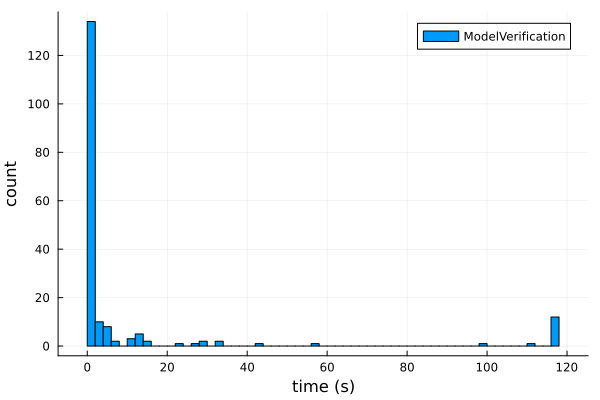

In [23]:
mv_df = DataFrame(CSV.File("./result.csv", header=true))
mv_df[mv_df.time .> 116, :time] .= 116
t = histogram(mv_df.time, bins=100, label="ModelVerification")
xlabel!("time (s)")
ylabel!("count")
display(t)

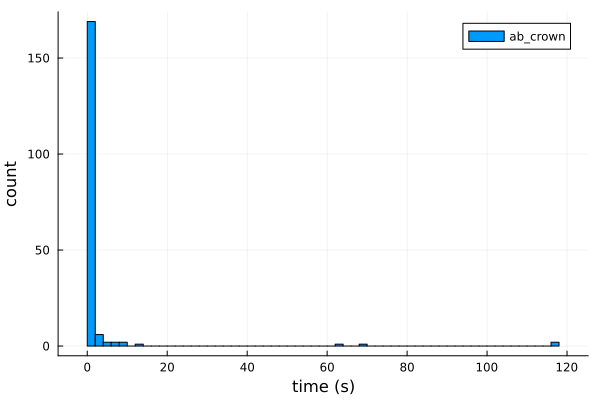

In [21]:
ab_df = DataFrame(CSV.File("./abcrown_result.csv", header=true))
ab_df[!,:value] = convert.(String15, ab_df[!,:value])
ab_df[ab_df.value .== "safe", :value] .= "holds"
ab_df[ab_df.value .== "unsafe", :value] .= "violated"
t = histogram(ab_df.time, bins=100, label="ab_crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

In [17]:
println(sum(ab_df.value .== "holds"))
println(sum(ab_df.value .== "violated"))
println(sum(ab_df.value .== "unknown"))

139
45
2


In [16]:
println(sum(mv_df.value .== "holds"))
println(sum(mv_df.value .== "violated"))
println(sum(mv_df.value .== "unknown"))

129
45
12


In [15]:
[mv_df[mv_df.value .!= ab_df.value, :value], ab_df[mv_df.value .!= ab_df.value, :value]]

2-element Vector{AbstractVector{String15}}:
 ["unknown", "unknown", "unknown", "unknown", "violated", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown"]
 ["holds", "holds", "holds", "holds", "unknown", "holds", "holds", "holds", "holds", "holds", "violated", "holds"]